In [213]:
import pandas as pd
import cv2
import geopandas as gpd
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import mapping
import cv2
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm_notebook 

from rasterio.features import rasterize
import rasterio.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [173]:
# raster_path = "/home/user/projects/africa_starving/data/images/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2"
# train_df = gpd.read_file("/home/user/projects/africa_starving/data/train/train/train_repr.geojson")
# raster_path = "/mnt/storage_4tb/ymi/crop_detection/Africa/data/images/2017-01-01/full/TCI.jp2"
root_dir = "/mnt/storage_4tb/ymi/crop_detection/Africa/data/images"
dates = os.listdir(root_dir)
raster_path = "/mnt/storage_4tb/ymi/crop_detection/Africa/data/images/2017-01-01/full/ndvi.tif"
train_df = gpd.read_file("/mnt/storage_4tb/ymi/crop_detection/train/train/train_repr.geojson")

In [333]:
srcs = []
for i in dates:
    raster_path = os.path.join(root_dir, i, "full/ndvi.tif")
    srcs.append(rasterio.open(raster_path, 'r'))
imgs = []
masks_bin = []
labels = []
for num, row in tqdm_notebook(train_df.iterrows()):
    try:
        cur_ims = []
        for src in srcs:
            masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=-10000, filled=False)
            mask = masked_image.mask[0]
            
            #print(mask.shape)
            img_to_test = rasterio.plot.reshape_as_image(masked_image.data)
            img_to_test[img_to_test < -1] = -1
    #         imgs.append(img_to_test[0])
            cur_img = ((img_to_test[:, :, 0] + 1) * 127).astype(np.uint8)
#             print(mask.shape)
#             print(cur_img.shape)
            cur_ims.append(cur_img)
        cur_ims = np.rollaxis(np.array(cur_ims), 0, 3)
        imgs.append(cur_ims)
        masks_bin.append(mask)
        labels.append(row["Crop_Id_Ne"])
        #masked_image = normalize(masked_image, x_min=norm_dict.get("B08").get('min'), x_max=norm_dict.get("B08").get('max'))
    except Exception as e:
        #print(e)
        continue
#     break
#     if num > 100:
#         break
# img_to_test = imgs[-1]

In [335]:
masked_image.mask[0].shape

(14, 9)

In [334]:
masks_bin[0].shape

(10, 14)

In [348]:
imgs[0].shape

(10, 14, 11)

In [241]:
list(np.repeat([[0, 255]], 11, axis=0).flatten())

[0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255,
 0,
 255]

In [242]:
list(range(11))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [344]:
class ColorDescriptor:
    def __init__(self, bins, ranges=[0, 180, 0, 256, 0, 256], channels=[0, 1, 2]):
        # store the number of bins for the 3D histogram
        self.bins = bins
        self.ranges = ranges
        self.channels = channels
        
    def describe(self, image, bin_mask):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
        
        #bin_mask = np.all(image != 0, axis=-1).astype(np.uint8)
        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, bin_mask)
        features.extend(hist)

        # return the feature vector
        return features
    
    def histogram(self, image, bn_mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel
        hists = []
        if len(image.shape) == 3:
            for i in range(image.shape[-1]):
                hist = cv2.calcHist([image[:, :, i]], [0], bn_mask, self.bins,
                    [0, 256])
                hists.append(hist)
        else:
            hists = cv2.calcHist([image], [0], None, self.bins, [0, 256])
        #print(len(hists))
        hists = np.array(hists)
        #print(hists.shape)
        hist = cv2.normalize(hists, hists).flatten()

        # return the histogram
        return hist

In [345]:
cv2.calcHist([imgs[0][:3]],
             [0, 1, 2],
             None,
             [16, 16, 16],
             [0, 255, 0, 255, 0, 255]).shape

(16, 16, 16)

In [346]:
masks

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True],
       [ True, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True],
       [ True,  True, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True],
       [ True,  True, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True, False, False, False,  True,  True,  True,  True,
         

In [350]:
cd = ColorDescriptor([16])

hists = []
for img, mask in zip(imgs, masks_bin):
    hists.append(cd.describe(img, mask.astype(np.uint8)))

(10, 14, 11)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(10, 14)
(10, 14, 11)
(19, 17, 11)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(19, 17)
(19, 17, 11)
(12, 12, 11)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(12, 12)
(12, 12, 11)
(22, 16, 11)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16

(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(36, 26)
(36, 26, 11)
(29, 8, 11)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(29, 8)
(29, 8, 11)
(31, 10, 11)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(31, 10)
(31, 10, 11)
(13, 8, 11)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(13, 8)
(13, 8, 11)
(30, 11, 11)
(30, 11, 11)
(30, 11)
(30, 11, 11)
(30, 11)
(30, 11, 11

(22, 30)
(22, 30, 11)
(22, 30)
(22, 30, 11)
(20, 25, 11)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(20, 25)
(20, 25, 11)
(14, 18, 11)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(14, 18)
(14, 18, 11)
(18, 22, 11)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(18, 22)
(18, 22, 11)
(21, 27, 11)
(21, 27, 11)
(21, 27)
(21, 27, 11)
(21, 27)
(21, 27, 11)
(21, 27)
(21, 27, 11)
(21, 27)
(21, 27, 11)
(21, 27)
(21, 27, 11)
(21, 27)
(21, 27

(28, 24)
(28, 24, 11)
(28, 24)
(28, 24, 11)
(28, 24)
(28, 24, 11)
(28, 24)
(28, 24, 11)
(25, 29, 11)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(25, 29)
(25, 29, 11)
(20, 20, 11)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(20, 20)
(20, 20, 11)
(15, 15, 11)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(15, 15)
(15, 15, 11)
(10, 26, 11)
(10, 26, 11)
(10, 26)
(10, 26, 11)
(10, 26)
(10, 26, 11)
(10, 26)
(10, 26, 11)
(10, 26)
(10, 26

(8, 8)
(8, 8, 11)
(8, 8)
(8, 8, 11)
(8, 8)
(8, 8, 11)
(17, 15, 11)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(10, 10, 11)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(10, 10)
(10, 10, 11)
(11, 11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(11, 11)
(11, 11, 11)
(10, 8, 11)
(10, 8, 11)
(10, 8)
(10, 8, 11)
(10, 8)
(10, 8, 11)
(10, 8)
(10, 8, 11)
(10, 8)
(10, 8, 11)
(10, 8)
(10, 8, 11)
(10, 8)
(10, 8, 11

(16, 19)
(16, 19, 11)
(16, 19)
(16, 19, 11)
(16, 19)
(16, 19, 11)
(30, 20, 11)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(29, 19, 11)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(29, 19)
(29, 19, 11)
(27, 17, 11)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(27, 17)
(27, 17, 11)
(22, 16, 11)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16, 11)
(22, 16)
(22, 16

(12, 17)
(12, 17, 11)
(12, 17)
(12, 17, 11)
(12, 17)
(12, 17, 11)
(12, 17)
(12, 17, 11)
(12, 17)
(12, 17, 11)
(12, 17)
(12, 17, 11)
(11, 19, 11)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(11, 19)
(11, 19, 11)
(7, 7, 11)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(7, 7)
(7, 7, 11)
(13, 19, 11)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 19)
(13, 19, 11)
(13, 24, 11)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11

(14, 11)
(14, 11, 11)
(11, 29, 11)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(11, 29)
(11, 29, 11)
(9, 20, 11)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(9, 20)
(9, 20, 11)
(25, 23, 11)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(25, 23)
(25, 23, 11)
(23, 26, 11)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 11)
(23, 26)
(23, 26, 

(43, 22)
(43, 22, 11)
(43, 22)
(43, 22, 11)
(43, 22)
(43, 22, 11)
(43, 22)
(43, 22, 11)
(43, 22)
(43, 22, 11)
(43, 22)
(43, 22, 11)
(43, 22)
(43, 22, 11)
(39, 15, 11)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(39, 15)
(39, 15, 11)
(24, 12, 11)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(24, 12)
(24, 12, 11)
(28, 14, 11)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(28, 14)
(28, 14, 11)
(13, 10, 11)
(13, 10, 11)
(13, 10)
(13, 10

(53, 40)
(53, 40, 11)
(53, 40)
(53, 40, 11)
(53, 40)
(53, 40, 11)
(53, 40)
(53, 40, 11)
(53, 40)
(53, 40, 11)
(20, 14, 11)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(20, 14)
(20, 14, 11)
(21, 24, 11)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(21, 24)
(21, 24, 11)
(23, 23, 11)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(35, 16, 11)
(35, 16, 11)
(35, 16)
(35, 16, 11)
(35, 16)
(35, 16, 11)
(35, 16)
(35, 16

(21, 16)
(21, 16, 11)
(21, 16)
(21, 16, 11)
(21, 16)
(21, 16, 11)
(21, 16)
(21, 16, 11)
(33, 27, 11)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(33, 27)
(33, 27, 11)
(29, 23, 11)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(29, 23)
(29, 23, 11)
(30, 22, 11)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 22)
(30, 22, 11)
(30, 20, 11)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20, 11)
(30, 20)
(30, 20

(23, 15)
(23, 15, 11)
(23, 15)
(23, 15, 11)
(23, 15)
(23, 15, 11)
(25, 18, 11)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(25, 18)
(25, 18, 11)
(31, 21, 11)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(31, 21)
(31, 21, 11)
(25, 25, 11)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(25, 25)
(25, 25, 11)
(24, 23, 11)
(24, 23, 11)
(24, 23)
(24, 23, 11)
(24, 23)
(24, 23, 11)
(24, 23)
(24, 23, 11)
(24, 23)
(24, 23, 11)
(24, 23)
(24, 23

(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(24, 21)
(24, 21, 11)
(15, 20, 11)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(15, 20)
(15, 20, 11)
(11, 25, 11)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(11, 25)
(11, 25, 11)
(17, 28, 11)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11)
(17, 28)
(17, 28, 11

(28, 23)
(28, 23, 11)
(28, 23)
(28, 23, 11)
(28, 23)
(28, 23, 11)
(28, 23)
(28, 23, 11)
(28, 23)
(28, 23, 11)
(28, 23)
(28, 23, 11)
(28, 23)
(28, 23, 11)
(26, 22, 11)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(26, 22)
(26, 22, 11)
(22, 19, 11)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(22, 19)
(22, 19, 11)
(21, 21, 11)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 20, 11)
(21, 20, 11)
(21, 20)
(21, 20

(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(23, 23)
(23, 23, 11)
(21, 22, 11)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(21, 22)
(21, 22, 11)
(16, 15, 11)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(16, 15)
(16, 15, 11)
(20, 19, 11)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(20, 19)
(20, 19, 11)
(18, 17, 11)
(18, 17

(18, 15)
(18, 15, 11)
(18, 15)
(18, 15, 11)
(20, 23, 11)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 23)
(20, 23, 11)
(20, 22, 11)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(20, 22)
(20, 22, 11)
(16, 20, 11)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(16, 20)
(16, 20, 11)
(14, 20, 11)
(14, 20, 11)
(14, 20)
(14, 20, 11)
(14, 20)
(14, 20, 11)
(14, 20)
(14, 20, 11)
(14, 20)
(14, 20, 11)
(14, 20)
(14, 20, 11)
(14, 20)
(14, 20

(16, 16)
(16, 16, 11)
(16, 16)
(16, 16, 11)
(16, 16)
(16, 16, 11)
(16, 16)
(16, 16, 11)
(16, 16)
(16, 16, 11)
(16, 16)
(16, 16, 11)
(36, 38, 11)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(36, 38)
(36, 38, 11)
(17, 15, 11)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(17, 15)
(17, 15, 11)
(21, 21, 11)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(21, 21)
(21, 21, 11)
(16, 14, 11)
(16, 14, 11)
(16, 14)
(16, 14, 11)
(16, 14)
(16, 14

(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(19, 18)
(19, 18, 11)
(15, 19, 11)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(15, 19)
(15, 19, 11)
(13, 24, 11)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(13, 24)
(13, 24, 11)
(21, 23, 11)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11)
(21, 23)
(21, 23, 11

In [351]:
len(hists)

2494

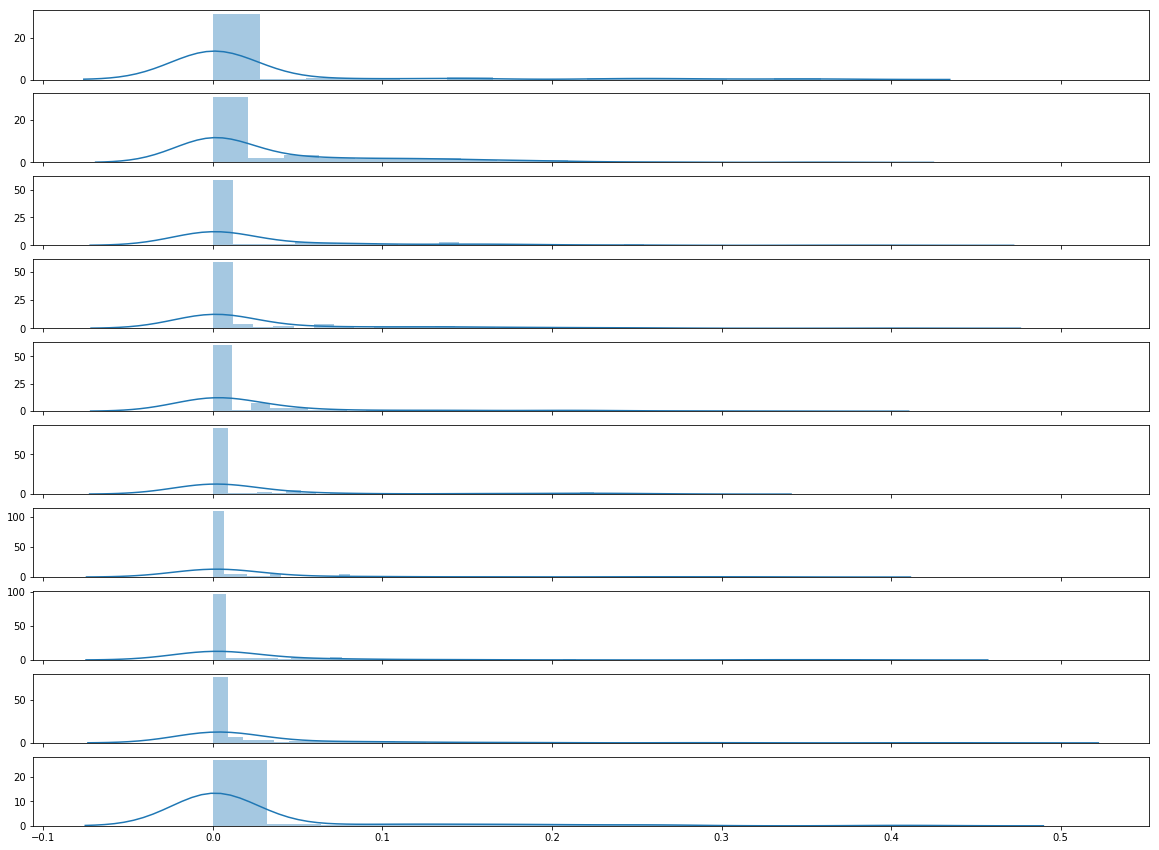

In [352]:
# plot

f, axes = plt.subplots(len(hists[:10]), 1, figsize=(20, 15), sharex=True)
for num, i in enumerate(hists[110:120]):
    sns.distplot(i, ax=axes[num])


In [353]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    # return the chi-squared distance
    return d

In [354]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [355]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    lbls = unique_labels(y_true, y_pred)
    lbls = [int(lbl) - 1 for lbl in lbls]
    classes = classes[lbls]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [356]:
len(hists[0])

176

In [357]:
neigh = KNeighborsClassifier(n_neighbors=3, metric=chi2_distance)

cross_val_score(neigh, hists, labels, cv=5, n_jobs=-1, verbose=3)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.3333333333333333, total= 1.5min
[CV] ...................... , score=0.32595573440643866, total= 1.5min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min


[CV] ....................... , score=0.3413173652694611, total= 1.5min
[CV] ....................... , score=0.4012096774193548, total= 1.5min
[CV] ....................... , score=0.4274193548387097, total= 1.5min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


array([0.33333333, 0.34131737, 0.32595573, 0.40120968, 0.42741935])

In [358]:
from sklearn.model_selection import train_test_split

In [359]:
X_train, X_test, y_train, y_test = train_test_split(
    hists, labels, test_size=0.2, random_state=42)

In [360]:
neigh = KNeighborsClassifier(n_neighbors=3, metric=chi2_distance, n_jobs=-1)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function chi2_distance at 0x7f810dd7b048>,
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [361]:
y_pred = neigh.predict(X_test[:500])

In [362]:
y_test = y_test[:500]

In [363]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.4649298597194389

In [364]:
# class_names = pd.read_csv("/home/user/projects/africa_starving/data/crop_id_list.csv")
class_names = pd.read_csv("/mnt/storage_4tb/ymi/crop_detection/Africa/data/crop_id_list.csv")

In [365]:
class_names['crop'].values

array(['Cotton', 'Dates', 'Grass', 'Lucern', 'Maize', 'Pecan', 'Vacant',
       'Vineyard', 'Vineyard & Pecan ("Intercrop")'], dtype=object)

Confusion matrix, without normalization
[[ 10   0   0   4   0   0   3   2   0]
 [  0   0   1   0   0   0   0   0   1]
 [  2   0   5   1   1   0   0   5   0]
 [  3   0   4  63   4   1   0  30   0]
 [  5   1   4  17  26   0   3  17   1]
 [  2   1   1   4   1   8   1  15   0]
 [  7   0   4  12   3   2   7  21   0]
 [ 13   0   4  33  13   3   5 112   1]
 [  0   0   1   2   0   0   0   8   1]]
Normalized confusion matrix
[[0.52631579 0.         0.         0.21052632 0.         0.
  0.15789474 0.10526316 0.        ]
 [0.         0.         0.5        0.         0.         0.
  0.         0.         0.5       ]
 [0.14285714 0.         0.35714286 0.07142857 0.07142857 0.
  0.         0.35714286 0.        ]
 [0.02857143 0.         0.03809524 0.6        0.03809524 0.00952381
  0.         0.28571429 0.        ]
 [0.06756757 0.01351351 0.05405405 0.22972973 0.35135135 0.
  0.04054054 0.22972973 0.01351351]
 [0.06060606 0.03030303 0.03030303 0.12121212 0.03030303 0.24242424
  0.03030303 0.45454545 

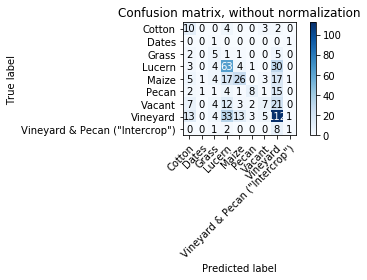

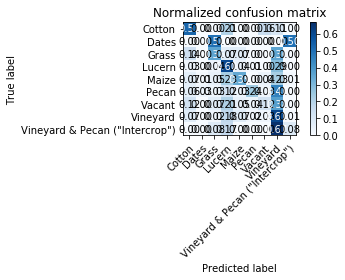

In [366]:
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names['crop'].values,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names['crop'].values, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
hists[0].shape